# Google Colaboratory の準備

本ファイルは、`notebook/1-1_painting.ipynb`をGoogle Colaboratoryで実行するためのノートブックです。  
あらかじめ、`notebook/colab/1-0_prepare_colab.ipynb`の手順を実行し、Googleドライブにリファレンス環境（ソフトウェア）のリポジトリとデータセットの準備が完了していることを確認してください。

## GPUの指定

Google Colaboratoryのメニューバーの「ランタイム」から「ランタイムのタイプを変更」を選択し、
ハードウェア アクセラレータを**GPU**に指定した上で、本ファイルを実行してください。

## ライブラリのインストール

In [ ]:
!pip install -q torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q nuscenes-devkit

!pip install -q fire tensorboardX protobuf opencv-python
!pip install -q numba scikit-image scipy pillow

     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:24tcmalloc: large alloc 1147494400 bytes == 0x3a47e000 @  0x7f5a666ef615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:27tcmalloc: large alloc 1434370048 bytes == 0x7ead4000 @  0x7f5a666ef615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.2 MB/s eta 0:00:01tcmalloc: large alloc 1445945344 bytes == 0xd42c0000 @  0x7f5a666ef615 0x592b76 0x4df71e 0x59afff 0x515655 0x

In [ ]:
# spconv v1.2.1 のインストール

!git clone --depth 1 --recursive  -b v1.2.1 https://github.com/traveller59/spconv.git
%cd spconv
!SPCONV_FORCE_BUILD_CUDA=1 python setup.py bdist_wheel
!pip install ./dist/spconv*

Cloning into 'spconv'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 118 (delta 16), reused 32 (delta 1), pack-reused 0
Receiving objects: 100% (118/118), 234.67 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Submodule 'third_party/cutlass' (https://github.com/NVIDIA/cutlass) registered for path 'third_party/cutlass'
Submodule 'third_party/mp11' (https://github.com/boostorg/mp11) registered for path 'third_party/mp11'
Submodule 'third_party/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'third_party/pybind11'
Cloning into '/content/spconv/third_party/cutlass'...
remote: Enumerating objects: 16512, done.        
remote: Counting objects: 100% (567/567), done.        
remote: Compressing objects: 100% (297/297), done.        
remote: Total 16512 (delta 257), reused 529 (delta 249), pack-reused 15945        
Receiving objects: 100% (16512/1651

## Googleドライブをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# WORK_DIRのパスは自身の作業ディレクトリに変更してください。

WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/work/"
%cd $WORK_DIR

# パスを合わせるため、リポジトリのnotebookディレクトリに移動
%cd ./6th-ai-reference2/notebook

/content/drive/MyDrive/Colab Notebooks/work
/content/drive/MyDrive/Colab Notebooks/work/6th-ai-reference2/notebook


以下より、`notebook/1-1_painting.ipynb`と同じ内容です。

# 概要

本ファイルでは、データセット(3d_labels)のカメラ画像(CAM_FRONT)に対してセグメンテーションを実施し、Lidarの点群データと結合した拡張点群を生成します。

手順は、次の通りです。

1. セマンティックセグメンテーション  
  カメラ画像に対してセマンティックセグメンテーションを行い、各ピクセルのクラススコアを取得  
　入力：画像  (H, W, 3)  
　出力：セグメンテーションスコア  (H, W, C)


2. 融合 (点群のペインティング)  
  算出したセグメンテーション結果をLidarの点群データに結合し、拡張点群データを作成  
　入力：class_scores, 点群データ(bin)  (x,y,z,intensity)  
　出力：拡張点群データ(bin)  (x, y, z, intensity, C1, C2, C3)


3. 可視化
  - セグメンテーション結果を画像にオーバーラップして表示
  - 点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示

## Output

本ファイルを実行することで、`data/3d_labels_painted`ディレクトリを生成し、拡張点群データ(bin)を保存します。

```
└ data
    ├ 3d_labels
    └ 3d_labels_painted  <-- 本ファイルにて生成されます
        ├ maps
        ├ samples
            ├ CAM_FRONT
            └ LIDAR_TOP  <-- 拡張点群データが格納されます
        └ v1.0-trainval
```

# 準備
## ライブラリのインポート

In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

import cv2
import torch
from nuscenes.nuscenes import NuScenes

from utils.pointcloud_seg import (get_segmentation_score,
                                  map_pointcloud_to_image, overlap_seg)
from utils.vis_pointcloud import get_figure_data, view_pointcloud

# インスタンス単体でのペインティング処理
ペインティング処理の動作を確認するため、インスタンス単体での推論を行います。

## 読み込みファイルのパス設定

In [ ]:
dataset_path = "../data/3d_labels"

# シーンIDとフレームIDの選択
scene_id = 29
frame_id = 73

## datasetの読み込み

In [ ]:
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path, verbose=True)

assert scene_id < len(nusc.scene), \
     f"SceneIDの指定値:{scene_id}が総シーン数:{len(nusc.scene)}を超えています。"

target_scene = nusc.scene[scene_id]
print(f"SceneID: {scene_id}")
print(f"  総フレーム数: {target_scene['nbr_samples']}")
print(f"FrameID: {frame_id}")

assert frame_id < target_scene["nbr_samples"], \
     f"FrameIDの指定値:{frame_id}がフレーム数:{target_scene['nbr_samples']}を超えています。"

sample_token = target_scene['first_sample_token']

for i in range(frame_id):
    sample = nusc.get('sample', sample_token)
    sample_token = sample['next']

sample_record = nusc.get('sample', sample_token)

test_key = f"{target_scene['name']}_{frame_id:0>2}"
print(f"test_key: {test_key}")

Loading NuScenes tables for version v1.0-trainval...
20 category,
8 attribute,
4 visibility,
2176 instance,
2 sensor,
74 calibrated_sensor,
2475 ego_pose,
37 log,
37 scene,
2475 sample,
4950 sample_data,
42142 sample_annotation,
37 map,
Done loading in 6.632 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
SceneID: 29
  総フレーム数: 183
FrameID: 73
test_key: scene-0109_73


In [ ]:
# LidarとCamのtokenを取得
pointsensor_token = sample_record['data']['LIDAR_TOP']
camera_token = sample_record['data']['CAM_FRONT']
# LidarとCamのレコードを取得
pointsensor = nusc.get('sample_data', pointsensor_token)
cam = nusc.get('sample_data', camera_token)

# inputデータの形式で各メタ情報を取得
cam_path = os.path.join(nusc.dataroot, cam['filename'])
lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
cam_ego_pose = nusc.get('ego_pose', cam['ego_pose_token'])
cam_calibration = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
lidar_ego_pose = nusc.get('ego_pose', pointsensor['ego_pose_token'])
lidar_calibration = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

# 1. セグメンテーション

第1ステップでは、カメラ画像に対して、セマンティックセグメンテーションを実行し、ピクセルごとのセグメンテーションスコアを取得します。

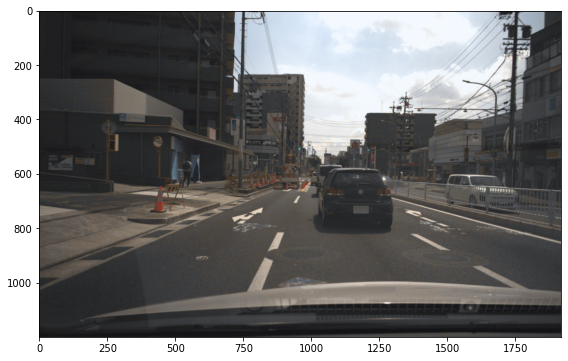

In [ ]:
# 入力画像の確認
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

## セグメンテーションモデルの定義

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 学習済みのdeeplabv3モデルをロード
model_seg = torch.hub.load('pytorch/vision:v0.6.0',
                           'deeplabv3_resnet101', pretrained=True)
model_seg.eval()
model_seg.to(device)

print("Segmentation Model Loaded.")

Using cuda device


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Segmentation Model Loaded.


## セグメンテーションモデルの推論

今回のモデルの推論で出力されるスコアは、次の3クラスです。

1. background
2. car
3. person

In [ ]:
class_scores = get_segmentation_score(cam_path, model_seg, device)

print("class_scores shape: ", class_scores.shape)  # (H, W, C)

class_scores shape:  (1200, 1920, 3)


# 2. 融合 (点群のペインティング) 

セグメンテーションスコアを点群に投影し、点群の次元にセグメンテーションスコアを追加することで拡張点群を取得します。  
点群の次元は (x, y, z, r) から (x, y, z, r, C1, C2, C3) へ拡張されます。

In [ ]:
# Lidar点群を画像に投影して画像座標を取得
points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                    lidar_path,
                                                    cam_ego_pose,
                                                    lidar_ego_pose,
                                                    cam_calibration,
                                                    lidar_calibration)

print("points_mask", points_mask.shape)   # 画像範囲でマスクした点群 (N, pcd_dim)
print("points_image", points_image.shape)  # (N, 2)  2:カメラ画像のx,y軸

points_mask (39581, 4)
points_image (39581, 2)


In [ ]:
# 点群データとセグメンテーションを結合し、拡張点群データを作成
class_num = class_scores.shape[2]

# points_image は x,y が画像座標で、cols, rows であるのに対し、
# class_score は (rows, cols) なので、以下のインデックスの値は 1 → 0 と逆になる
point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
point_scores = point_scores.reshape(-1, class_num)

print(point_scores.shape)  # (N, class_num)

(39581, 3)


In [ ]:
painted_lidar = np.hstack([points_mask, point_scores])
painted_lidar = painted_lidar.astype(np.float32)

print(painted_lidar.shape)  # (N, pcd_dim + class_num)

(39581, 7)


## 可視化

### セグメンテーション + 画像

セグメンテーション結果を画像にオーバーラップして表示します。

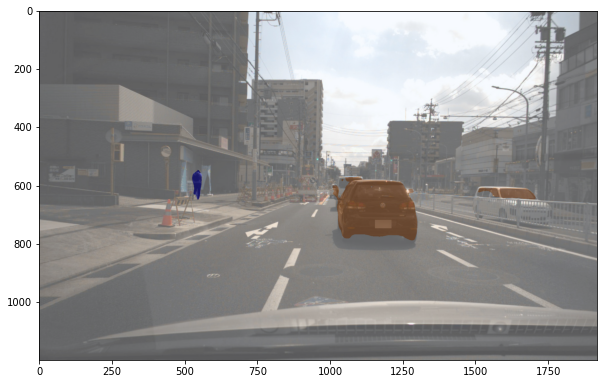

In [ ]:
img = Image.open(cam_path)
img_np = np.array(img)

img_seg = overlap_seg(img_np,
                      class_scores,
                      opacity=0.3)

plt.figure(figsize=(10, 8))
plt.imshow(img_seg)

### セグメンテーション + 点群

点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示します。

In [ ]:
pc_data = painted_lidar[::4]  # 可視化処理の軽減のため1/4にデータ間引き

# 拡張点群のセグメンテーションの色
segcolor_dict = {0: "darkgray",  # background
                 1: "orange",    # car
                 2: "blue"}      # person

points_xyz = pc_data[:, :3]  # (x, y, z)を抽出
points_class = np.argmax(pc_data[:, 4:], axis=1)  # Classを抽出
points_colors = [segcolor_dict[i] for i in points_class]

fig = view_pointcloud(points_xyz, points_colors, mode="front")
fig.show()

# 全点群データに対してペインティング処理

拡張点群データ(bin)を生成し、`3d_labels_painted`ディレクトリに保存します。

In [ ]:
# 保存先ディレクトリの設定
save_dir = "../data/3d_labels_painted"

In [ ]:
# 保存先ディレクトリの作成
Path(save_dir).mkdir(exist_ok=True)
(Path(save_dir) / "samples").mkdir(exist_ok=True)
(Path(save_dir) / "samples/LIDAR_TOP").mkdir(exist_ok=True)

In [ ]:
# Lidarデータ以外の3d_labelsファイルを保存先ディレクトリにコピー
!cp -r {str(Path(dataset_path) / "maps")} {str(Path(save_dir))} 
!cp -r {str(Path(dataset_path) / "samples/CAM_FRONT")} {str(Path(save_dir) / "samples/CAM_FRONT")} 
!cp -r {str(Path(dataset_path) / "v1.0-trainval")} {str(Path(save_dir) / "v1.0-trainval")} 

全サンプルに対して、拡張点群データを生成し`3d_labels_painted/samples/LIDAR_TOP`に保存します。

In [ ]:
for sample_record in tqdm(nusc.sample):

    # LidarとCamのtokenを取得
    pointsensor_token = sample_record['data']['LIDAR_TOP']
    camera_token = sample_record['data']['CAM_FRONT']
    # LidarとCamのレコードを取得
    pointsensor = nusc.get('sample_data', pointsensor_token)
    cam = nusc.get('sample_data', camera_token)

    # inputデータの各メタ情報を取得
    cam_path = os.path.join(nusc.dataroot, cam['filename'])
    lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
    cam_ego_pose = nusc.get('ego_pose',
                            cam['ego_pose_token'])
    cam_calibration = nusc.get('calibrated_sensor',
                               cam['calibrated_sensor_token'])
    lidar_ego_pose = nusc.get('ego_pose',
                              pointsensor['ego_pose_token'])
    lidar_calibration = nusc.get('calibrated_sensor',
                                 pointsensor['calibrated_sensor_token'])

    # セグメンテーションモデルの推論
    class_scores = get_segmentation_score(cam_path, model_seg, device)

    # Lidar点群を画像に投影して画像座標を取得
    points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                        lidar_path,
                                                        cam_ego_pose,
                                                        lidar_ego_pose,
                                                        cam_calibration,
                                                        lidar_calibration)

    # 点群データとセグメンテーションを結合し、拡張点群データを作成
    class_num = class_scores.shape[2]
    point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
    point_scores = point_scores.reshape(-1, class_num)

    painted_lidar = np.hstack([points_mask, point_scores])
    painted_lidar = painted_lidar.astype(np.float32)

    # 拡張点群データbinを保存
    save_name = Path(save_dir) / "samples/LIDAR_TOP" / Path(lidar_path).name
    painted_lidar.tofile(save_name)

  0%|          | 0/2475 [00:00<?, ?it/s]

以上